In [ ]:
# connect to google drive, run this block again after every restart of runtime
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Regularizer_model_0109')

Mounted at /content/drive


In [ ]:
# !pip install matplotlib==3.1.1

In [ ]:
import os
import h5py
import time
import csv
import glob

import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras

from numpy import load
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import Conv3DTranspose
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import ELU
from tensorflow.keras.activations import linear
from tensorflow.keras.layers import Multiply
from tensorflow.keras.layers import Lambda
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import epsilon

import matplotlib
from matplotlib import pyplot
import matplotlib.pylab as plt 
import seaborn as sns

import ops_0516 as ops

In [ ]:
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.7.1


In [ ]:
# review (only review) GPU information, run when needed
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May 23 18:25:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    48W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# define the discriminator model
def define_discriminator(src_img_shape=(128,128,32,5), tar_img_shape=(128,128,32,4)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    # source image input
    in_src_image = Input(shape=src_img_shape) # 128*128*32*5
    # target image input
    in_target_image = Input(shape=tar_img_shape) # 128*128*32*4

    # concatenate images channel-wise
    merged = Concatenate()([in_src_image, in_target_image]) # 128*128*32*9
    # C64
    d = Conv3D(64, (4,4,4), padding='same', kernel_initializer=init)(merged) # 128*128*32*64
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv3D(128, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(d) # 64*64*16*128
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv3D(256, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(d) # 32*32*8*256
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv3D(512, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(d) # 16*16*4*512
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv3D(512, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(d) # 8*8*2*512
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv3D(512, (4,4,4), padding='same', kernel_initializer=init)(d) # 8*8*2*512
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    d = Conv3D(1, (4,4,4), padding='same', kernel_initializer=init)(d) # 8*8*2*1
    patch_out = Activation('sigmoid')(d)
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    # compile model
    opt = Adam(learning_rate=0.00002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    
    print("Discriminator Summary: \n")
    model.summary(positions = [.4, .68, .8, 1.])
    return model

In [ ]:
# define an encoder block
def encoder_block(layer_in, n_filters, strd=(2,2,2), batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv3D(n_filters, (3,3,3), strides=strd, padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

In [ ]:
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, strd=(2,2,2), dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv3DTranspose(n_filters, (3,3,3), strides=strd, padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

In [ ]:
# define the standalone generator model
def define_generator(src_image_shape=(128,128,32,4)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=src_image_shape) # 128*128*32*5

    # encoder model
    e0 = encoder_block(in_image, 128, strd=(1,1,1), batchnorm=True) # 128*128*32*128
    e1 = encoder_block(e0, 128, strd=(1,1,1), batchnorm=True) # 128*128*32*128
    e2 = encoder_block(e1, 128, strd=(1,1,1), batchnorm=True) # 128*128*32*128
    e3 = encoder_block(e2, 256, strd=(2,2,2), batchnorm=True) # 64*64*16*256
    e4 = encoder_block(e3, 256, strd=(1,1,1), batchnorm=True) # 64*64*16*256
    e4_ = encoder_block(e4, 256, strd=(1,1,1), batchnorm=True) # 64*64*16*256
    e5 = encoder_block(e4_, 512, strd=(2,2,2), batchnorm=True) # 32*32*8*512
    e6 = encoder_block(e5, 512, strd=(1,1,1), batchnorm=True) # 32*32*8*512
    e6_ = encoder_block(e6, 512, strd=(1,1,1), batchnorm=True) # 32*32*8*512
    e7 = encoder_block(e6_, 512, strd=(2,2,2), batchnorm=True) # 16*16*4*512
    e8 = encoder_block(e7, 512, strd=(1,1,1), batchnorm=True) # 16*16*4*512
    e8_ = encoder_block(e8, 512, strd=(1,1,1), batchnorm=True) # 16*16*4*512
    
    # bottleneck
    b = encoder_block(e8_, 512, strd=(2,2,2), batchnorm=True) # 8*8*2*512

    # decoder model
    d9 = Conv3DTranspose(512, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(b)  # 8*8*2*512
    d9 = BatchNormalization()(d9)
    # d9 = Dropout(0.5)(d9)
    d9 = LeakyReLU(alpha=0.2)(d9)

    d9_ = Conv3DTranspose(512, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(d9)  # 8*8*2*512
    d9_ = BatchNormalization()(d9_)
    # d9_ = Dropout(0.5)(d9_)
    d9_ = LeakyReLU(alpha=0.2)(d9_)

    d8 = Conv3DTranspose(512, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(d9_)  # 16*16*4*512
    d8 = BatchNormalization()(d8)
    d8 = LeakyReLU(alpha=0.2)(d8)

    d8_ = Conv3DTranspose(512, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(d8)  # 16*16*4*512
    d8_ = BatchNormalization()(d8_)
    d8_ = LeakyReLU(alpha=0.2)(d8_)

    d7 = decoder_block(d8_, e7, 512, strd=(1,1,1), dropout=True) # 16*16*4*1024

    d6 = Conv3DTranspose(512, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(d7)  # 32*32*8*512
    d6 = BatchNormalization()(d6)
    d6 = LeakyReLU(alpha=0.2)(d6)

    d6_ = Conv3DTranspose(512, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(d6)  # 32*32*8*512
    d6_ = BatchNormalization()(d6_)
    d6_ = LeakyReLU(alpha=0.2)(d6_)

    d5 = decoder_block(d6_, e5, 512, strd=(1,1,1), dropout=True) # 32*32*8*1024

    d4 = Conv3DTranspose(256, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(d5)  # 64*64*16*256
    d4 = BatchNormalization()(d4)
    d4 = LeakyReLU(alpha=0.2)(d4)

    d4_ = Conv3DTranspose(256, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(d4)  # 64*64*16*256
    d4_ = BatchNormalization()(d4_)
    d4_ = LeakyReLU(alpha=0.2)(d4_)

    d3 = decoder_block(d4_, e3, 256, strd=(1,1,1), dropout=True) # 64*64*16*512

    d2 = Conv3DTranspose(128, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(d3) # 128*128*32*128
    d2 = BatchNormalization()(d2)
    d2 = LeakyReLU(alpha=0.2)(d2)

    d1 = decoder_block(d2, e1, 128, strd=(1,1,1), dropout=True) # 128*128*32*256
    
    d0 = Conv3DTranspose(128, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(d1) # 128*128*32*128
    d0 = BatchNormalization()(d0)
    d0 = LeakyReLU(alpha=0.2)(d0)

    # output
    g = Conv3DTranspose(4, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(d0) # 128*128*32*4
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    
    print("Generator Summary: \n")
    model.summary(positions = [.4, .68, .8, 1.])
    return model

In [ ]:
# dataset pipeline
def get_data_from_filename(filename):
    npdata = np.load(filename.numpy())
    comp_mx, cfd_mx = npdata['arr_0'], npdata['arr_1']
    uvw_scaler = 1/7.0
    p_scaler = 1/25.0
    cfd_mx[:,:,:,0] *= uvw_scaler
    cfd_mx[:,:,:,1] *= uvw_scaler
    cfd_mx[:,:,:,2] *= uvw_scaler
    cfd_mx[:,:,:,3] *= p_scaler
    return comp_mx, cfd_mx

def get_data_wrapper(filename):
    # Assuming here that both your data and label is float type.
    comp_mx, cfd_mx = tf.py_function(get_data_from_filename, [filename], [tf.float32, tf.float32])
    return tf.data.Dataset.from_tensors((comp_mx, cfd_mx))

def set_shape(m1, m2):
    m1.set_shape((128, 128, 32, 7))
    m2.set_shape((128, 128, 32, 4))
    return m1, m2

# Create dataset of filenames.
test_percent = 0.1
batch_size = 2
npz_folder_path = "/content/drive/MyDrive/Regularizer_model_0109/Regularizer_PINN_Dataset"
filelist = glob.glob(npz_folder_path + '/*.npz')
train_num = int((len(filelist)/batch_size)*(1.0-test_percent))
print("number of data point in training set: ", train_num)
ds = tf.data.Dataset.from_tensor_slices(filelist)
ds = ds.flat_map(get_data_wrapper)
ds = ds.map(set_shape)
ds = ds.batch(batch_size)
ds_train = ds.take(train_num)
ds_test = ds.skip(train_num)

number of data point in training set:  900


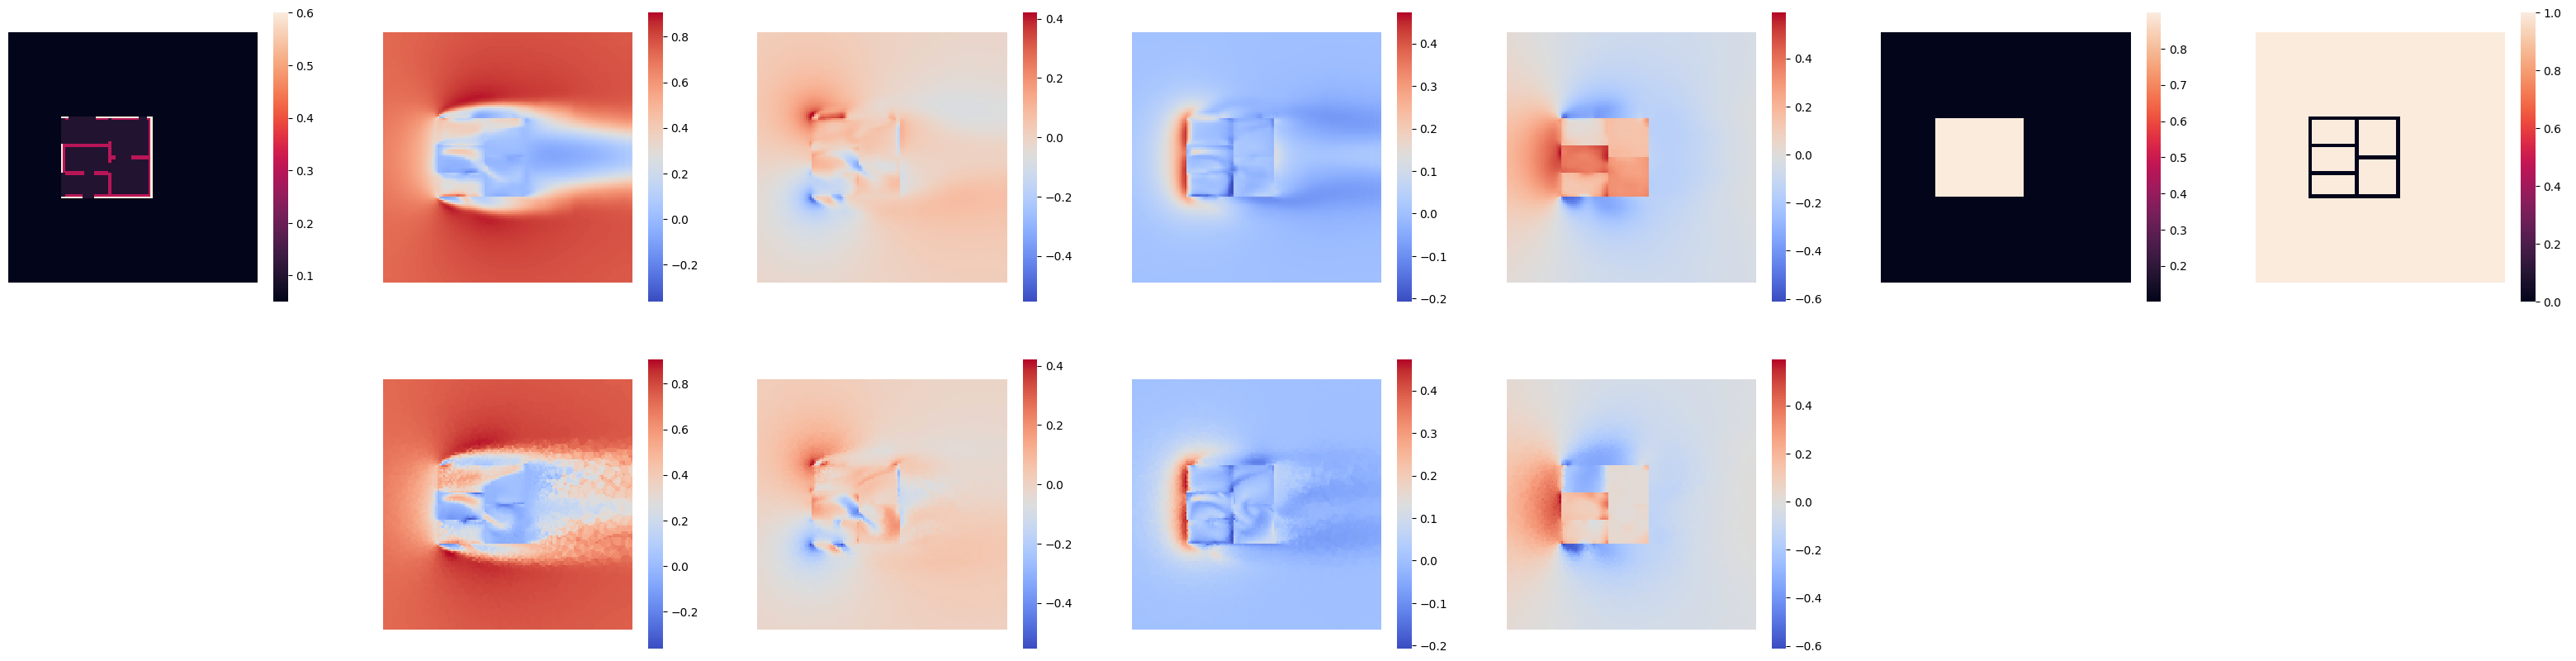

In [ ]:
# print data example
z = 10
for comp_mx, cfd_mx in ds_test.skip(6).take(1):
    bnd, u1, v1, w1, p1, mask1, mask2 = comp_mx.numpy()[0,:,:,:,0], comp_mx.numpy()[0,:,:,:,1], comp_mx.numpy()[0,:,:,:,2], comp_mx.numpy()[0,:,:,:,3], comp_mx.numpy()[0,:,:,:,4], comp_mx.numpy()[0,:,:,:,5], comp_mx.numpy()[0,:,:,:,6]
    u2, v2, w2, p2 = cfd_mx.numpy()[0,:,:,:,0], cfd_mx.numpy()[0,:,:,:,1], cfd_mx.numpy()[0,:,:,:,2], cfd_mx.numpy()[0,:,:,:,3]

    u_min, u_max = np.amin(u2[:,:,z], axis=(0,1)), np.amax(u2[:,:,z], axis=(0,1))
    v_min, v_max = np.amin(v2[:,:,z], axis=(0,1)), np.amax(v2[:,:,z], axis=(0,1))
    w_min, w_max = np.amin(w2[:,:,z], axis=(0,1)), np.amax(w2[:,:,z], axis=(0,1))
    p_min, p_max = np.amin(p2[:,:,z], axis=(0,1)), np.amax(p2[:,:,z], axis=(0,1))

    fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(40, 10))
    sns.heatmap(bnd[:,:,z].T, ax = ax[0,0], square = True)
    ax[0,0].invert_yaxis()
    ax[0,0].axis('off')
    sns.heatmap(u1[:,:,z].T, ax = ax[0,1], square = True, cmap="coolwarm", vmin=u_min, vmax=u_max)
    ax[0,1].invert_yaxis()
    ax[0,1].axis('off')
    sns.heatmap(v1[:,:,z].T, ax = ax[0,2], square = True, cmap="coolwarm", vmin=v_min, vmax=v_max)
    ax[0,2].invert_yaxis()
    ax[0,2].axis('off')
    sns.heatmap(w1[:,:,z].T, ax = ax[0,3], square = True, cmap="coolwarm", vmin=w_min, vmax=w_max)
    ax[0,3].invert_yaxis()
    ax[0,3].axis('off')
    sns.heatmap(p1[:,:,z].T, ax = ax[0,4], square = True, cmap="coolwarm", vmin=p_min, vmax=p_max)
    ax[0,4].invert_yaxis()
    ax[0,4].axis('off')
    sns.heatmap(mask1[:,:,z].T, ax = ax[0,5], square = True)
    ax[0,5].invert_yaxis()
    ax[0,5].axis('off')
    sns.heatmap(mask2[:,:,z].T, ax = ax[0,6], square = True)
    ax[0,6].invert_yaxis()
    ax[0,6].axis('off')

    ax[1,0].axis('off')
    sns.heatmap(u2[:,:,z].T, ax = ax[1,1], square = True, cmap="coolwarm", vmin=u_min, vmax=u_max)
    ax[1,1].invert_yaxis()
    ax[1,1].axis('off')
    sns.heatmap(v2[:,:,z].T, ax = ax[1,2], square = True, cmap="coolwarm", vmin=v_min, vmax=v_max)
    ax[1,2].invert_yaxis()
    ax[1,2].axis('off')
    sns.heatmap(w2[:,:,z].T, ax = ax[1,3], square = True, cmap="coolwarm", vmin=w_min, vmax=w_max)
    ax[1,3].invert_yaxis()
    ax[1,3].axis('off')
    sns.heatmap(p2[:,:,z].T, ax = ax[1,4], square = True, cmap="coolwarm", vmin=p_min, vmax=p_max)
    ax[1,4].invert_yaxis()
    ax[1,4].axis('off')
    ax[1,5].axis('off')
    ax[1,6].axis('off')

In [ ]:
def discriminator_loss(real_output, fake_output):
    fake_loss = tf.math.log(1 - fake_output + epsilon())
    real_loss = tf.math.log(real_output + epsilon())
    return tf.math.reduce_mean(-(fake_loss + real_loss))

In [ ]:
discriminator = define_discriminator()
generator = define_generator()

generator_optimizer = Adam(0.000002, beta_1=0.9) # learning rate start as 0.00002 ep96 0.000002
discriminator_optimizer = Adam(0.00002, beta_1=0.9) # learning rate start as 0.00002

Discriminator Summary: 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #     Connected to        
 input_1 (InputLayer)                  [(None, 128, 128, 32, 5)]  0           []                  
                                                                                                  
 input_2 (InputLayer)                  [(None, 128, 128, 32, 4)]  0           []                  
                                                                                                  
 concatenate (Concatenate)             (None, 128, 128, 32, 9)    0           ['input_1[0][0]',   
                                                                               'input_2[0][0]']   
                                                                                                  
 conv3d (Conv3D)                       (None, 128, 128, 32, 64)   369

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


                                                                              n_2[0][0]']         
                                                                                                  
 conv3d_3 (Conv3D)                     (None, 16, 16, 4, 512)     8389120     ['leaky_re_lu_2[0][0
                                                                              ]']                 
                                                                                                  
 batch_normalization_3 (BatchNormaliza  (None, 16, 16, 4, 512)    2048        ['conv3d_3[0][0]']  
 tion)                                                                                            
                                                                                                  
 leaky_re_lu_3 (LeakyReLU)             (None, 16, 16, 4, 512)     0           ['batch_normalizatio
                                                                              n_3[0][0]']         
          

In [ ]:
# self-defined physics loss function based on continunity euqation and pressure poisson equation 
def calculate_physics_loss(generated_img, true_img, mask, dx):
    uvw_scaler = 1/7.0
    p_scaler = 1/25.0

    true_img_scale_back = tf.math.multiply(true_img, tf.constant(([1.0/uvw_scaler, 1.0/uvw_scaler, 1.0/uvw_scaler, 1.0/p_scaler])))
    generate_img_scale_back = tf.math.multiply(generated_img, tf.constant(([1.0/uvw_scaler, 1.0/uvw_scaler, 1.0/uvw_scaler, 1.0/p_scaler])))
    
    true_vel_grad = ops.get_velocity_grad(true_img_scale_back, dx, dx, dx)
    true_strain_rate_2_HR = tf.math.reduce_mean(tf.math.reduce_mean(tf.math.reduce_mean(ops.get_strain_rate_mag2(true_vel_grad), axis=1, keepdims=True), axis=2, keepdims=True), axis=3, keepdims=True)
    true_continuity_res = ops.get_continuity_residual(true_vel_grad)
    true_pressure_res = ops.get_pressure_residual(true_img_scale_back, true_vel_grad, dx, dx, dx)
    true_continuity_loss = tf.math.square(true_continuity_res) / true_strain_rate_2_HR
    true_pressure_loss = tf.math.square(true_pressure_res) / true_strain_rate_2_HR**2

    pred_vel_grad = ops.get_velocity_grad(generate_img_scale_back, dx, dx, dx)
    pred_strain_rate_2_HR = tf.math.reduce_mean(tf.math.reduce_mean(tf.math.reduce_mean(ops.get_strain_rate_mag2(pred_vel_grad), axis=1, keepdims=True), axis=2, keepdims=True), axis=3, keepdims=True)
    pred_continuity_res = ops.get_continuity_residual(pred_vel_grad)
    pred_pressure_res = ops.get_pressure_residual(generate_img_scale_back, pred_vel_grad, dx, dx, dx)
    pred_continuity_loss = tf.math.square(pred_continuity_res) / pred_strain_rate_2_HR
    pred_pressure_loss = tf.math.square(pred_pressure_res) / pred_strain_rate_2_HR**2

    continuity_loss_mx, pressure_loss_mx = tf.nn.relu(pred_continuity_loss-true_continuity_loss), tf.nn.relu(pred_pressure_loss-true_pressure_loss)
    continuity_loss_mx, pressure_loss_mx = tf.math.multiply(continuity_loss_mx[:,:,:,:,0], mask), tf.math.multiply(pressure_loss_mx[:,:,:,:,0], mask)

    return tf.math.reduce_mean(continuity_loss_mx), tf.math.reduce_mean(pressure_loss_mx)

In [ ]:
# test physics loss function
for comp_mx, cfd_mx in ds_test.skip(6).take(1):
    dx = 0.25
    continuity_loss, pressure_loss = calculate_physics_loss(cfd_mx[0:1,:,:,:,:], cfd_mx[0:1,:,:,:,:], comp_mx[0:1,1:-1,1:-1,1:-1,-1], dx)
    print("continuity_loss: ", continuity_loss)
    print("pressure_loss: ", pressure_loss)

continuity_loss:  tf.Tensor(0.0, shape=(), dtype=float32)
pressure_loss:  tf.Tensor(0.0, shape=(), dtype=float32)


In [ ]:
@tf.function
def resnet_PRE_train_iteration(comp_mx, cfd_mx):
    with tf.GradientTape() as gen_tape:
        generated_images = generator(comp_mx[:,:,:,:,:4])
        
        mae = MeanAbsoluteError()(generated_images, cfd_mx, sample_weight=comp_mx[:,:,:,:,-2])
        prop = tf.math.reduce_mean(comp_mx[:,:,:,:,-2])
        mae_loss = tf.math.divide(mae, prop)
        gen_loss = mae_loss

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    return gen_loss

In [ ]:
@tf.function
def resnet_train_iteration(comp_mx, cfd_mx):
    lambda_phy = 0.005
    lambda_con = 0.5
    dx = 0.25
    with tf.GradientTape() as gen_tape:
        generated_images = generator(comp_mx[:,:,:,:,:4])

        continuity_loss, pressure_loss = calculate_physics_loss(generated_images, cfd_mx, comp_mx[:,1:-1,1:-1,1:-1,-1], dx)
        physics_loss = (1 - lambda_con) * pressure_loss + lambda_con * continuity_loss

        mae = MeanAbsoluteError()(generated_images, cfd_mx, sample_weight=comp_mx[:,:,:,:,-2])
        prop = tf.math.reduce_mean(comp_mx[:,:,:,:,-2])
        mae_loss = tf.math.divide(mae, prop)

        gen_loss = (1 - lambda_phy) * mae_loss + lambda_phy * physics_loss

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    return gen_loss, mae_loss, physics_loss

In [ ]:
@tf.function
def gan_train_iteration(comp_mx, cfd_mx):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        adversarial_ratio = 0.01
        
        generated_images = generator(comp_mx)
        real_output = discriminator([comp_mx, cfd_mx])
        fake_output = discriminator([comp_mx, generated_images])
        dis_loss = discriminator_loss(real_output, fake_output)
        
        mae = MeanAbsoluteError()(generated_images, cfd_mx, sample_weight=comp_mx[:,:,:,:,-1])
        prop = tf.math.reduce_mean(comp_mx[:,:,:,:,-1])
        gen_loss = tf.math.divide(mae, prop)

        adv_loss = tf.math.reduce_mean(-tf.math.log(fake_output + epsilon()))
        total_gen_loss = (1.0 - adversarial_ratio) * gen_loss + adversarial_ratio * adv_loss

    gradients_of_generator = gen_tape.gradient(total_gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(dis_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, dis_loss, adv_loss

In [ ]:
def train(dataset, epochs, mode = 'resnet', starting_epoch=0): # mode = "resnet" or "gan"
    f_gen = open("/content/drive/MyDrive/Regularizer_model_0109/regularizer_PINN_loss_0516.csv", "w")
    writer = csv.writer(f_gen)
    writer.writerow(list(range(train_num)))
    f_gen.close()
    
    f_mae = open("/content/drive/MyDrive/Regularizer_model_0109/regularizer_PINN_mae_loss_0516.csv", "w")
    writer = csv.writer(f_mae)
    writer.writerow(list(range(train_num)))
    f_mae.close()
    
    f_phy = open("/content/drive/MyDrive/Regularizer_model_0109/regularizer_PINN_phy_loss_0516.csv", "w")
    writer = csv.writer(f_phy)
    writer.writerow(list(range(train_num)))
    f_phy.close()
    
    if mode == "gan":
        f_dis = open("/content/drive/MyDrive/Regularizer_model_0109/regularizer_dis_loss_0516.csv", "w")
        writer = csv.writer(f_dis)
        writer.writerow(list(range(train_num)))
        f_dis.close()
    
    for epoch in range(epochs):
        gen_loss_list = []
        dis_loss_list = []
        mae_loss_list = []
        phy_loss_list = []
        start = time.time()
        if mode == "gan":
            for i, (comp_mx, cfd_mx) in enumerate(dataset):
                gen_loss, dis_loss, adv_loss = gan_train_iteration(comp_mx, cfd_mx)
                print('>%d, d[%.5f] g[%.5f] adv[%.5f]' % (i+1, dis_loss, gen_loss, adv_loss))
                gen_loss_list.append(gen_loss.numpy())
                dis_loss_list.append(dis_loss.numpy())
            with open('/content/drive/MyDrive/Regularizer_model_0109/regularizer_PINN_loss_0516.csv', 'a', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(gen_loss_list)
            with open('/content/drive/MyDrive/Regularizer_model_0109/regularizer_dis_loss_0516.csv', 'a', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(dis_loss_list)

        else: 
            for i, (comp_mx, cfd_mx) in enumerate(dataset):
                ###################################################################################
                # gen_loss = resnet_PRE_train_iteration(comp_mx, cfd_mx)
                # print('>%d, g[%.4f]' % (i+1, gen_loss))
                # gen_loss_list.append(gen_loss.numpy())
                ###################################################################################
                # note that gen_loss already include mae_loss and physics_loss, mae_loss and physics_loss here is only for display
                gen_loss, mae_loss, phy_loss = resnet_train_iteration(comp_mx, cfd_mx) 
                print('>%d, g[%.4f] mae[%.4f] phy[%.4f]' % (i+1, gen_loss, mae_loss, phy_loss))
                mae_loss_list.append(mae_loss.numpy())
                phy_loss_list.append(phy_loss.numpy())
                gen_loss_list.append(gen_loss.numpy())
                ###################################################################################
            with open('/content/drive/MyDrive/Regularizer_model_0109/regularizer_PINN_loss_0516.csv', 'a', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(gen_loss_list)
            with open('/content/drive/MyDrive/Regularizer_model_0109/regularizer_PINN_mae_loss_0516.csv', 'a', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(mae_loss_list)
            with open('/content/drive/MyDrive/Regularizer_model_0109/regularizer_PINN_phy_loss_0516.csv', 'a', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(phy_loss_list)

        # save the model every 10 epochs
        if (epoch+1) % 2 == 0:
            g_filename = '/content/drive/MyDrive/Regularizer_model_0109/Archive_models/0516/regularizer_PINN_model_0516_%06d.h5' % (starting_epoch+epoch+1)
            generator.save(g_filename)
            if mode == "gan":
                d_filename = '/content/drive/MyDrive/Regularizer_model_0109/regularizer_dis_model_0516_%06d.h5' % (starting_epoch+epoch+1)
                discriminator.save(d_filename)
                print('>save d_model: %s | save g_model: %s' % (d_filename, g_filename))
            else: 
                print('>save g_model: %s' % (g_filename))
        print('Time for epoch {} is {} sec'.format(starting_epoch + epoch + 1, time.time()-start))

In [ ]:
train(ds_train, epochs=50, mode = 'resnet', starting_epoch=250)

>1, g[0.0064] mae[0.0062] phy[0.0350]
>2, g[0.0061] mae[0.0059] phy[0.0387]
>3, g[0.0062] mae[0.0060] phy[0.0349]
>4, g[0.0048] mae[0.0046] phy[0.0402]
>5, g[0.0056] mae[0.0055] phy[0.0270]
>6, g[0.0062] mae[0.0061] phy[0.0290]
>7, g[0.0053] mae[0.0052] phy[0.0269]
>8, g[0.0059] mae[0.0057] phy[0.0390]
>9, g[0.0064] mae[0.0063] phy[0.0303]
>10, g[0.0063] mae[0.0061] phy[0.0318]
>11, g[0.0058] mae[0.0057] phy[0.0343]
>12, g[0.0054] mae[0.0052] phy[0.0389]
>13, g[0.0057] mae[0.0056] phy[0.0297]
>14, g[0.0061] mae[0.0060] phy[0.0274]
>15, g[0.0061] mae[0.0059] phy[0.0372]
>16, g[0.0057] mae[0.0056] phy[0.0374]
>17, g[0.0063] mae[0.0062] phy[0.0272]
>18, g[0.0060] mae[0.0058] phy[0.0382]
>19, g[0.0060] mae[0.0058] phy[0.0352]
>20, g[0.0065] mae[0.0064] phy[0.0359]
>21, g[0.0063] mae[0.0061] phy[0.0339]
>22, g[0.0056] mae[0.0055] phy[0.0275]
>23, g[0.0059] mae[0.0058] phy[0.0288]
>24, g[0.0053] mae[0.0052] phy[0.0271]
>25, g[0.0060] mae[0.0059] phy[0.0379]
>26, g[0.0057] mae[0.0056] phy[0.0

>900, g[0.0058] mae[0.0057] phy[0.0286]
>save g_model: /content/drive/MyDrive/Regularizer_model_0109/Archive_models/0516/regularizer_PINN_model_0516_000202.h5
Time for epoch 202 is 521.5708565711975 sec
>1, g[0.0063] mae[0.0061] phy[0.0338]
>2, g[0.0060] mae[0.0058] phy[0.0373]
>3, g[0.0062] mae[0.0061] phy[0.0335]
>4, g[0.0049] mae[0.0047] phy[0.0391]
>5, g[0.0057] mae[0.0056] phy[0.0263]
>6, g[0.0063] mae[0.0062] phy[0.0280]
>7, g[0.0054] mae[0.0053] phy[0.0260]
>8, g[0.0059] mae[0.0057] phy[0.0379]
>9, g[0.0064] mae[0.0063] phy[0.0296]
>10, g[0.0063] mae[0.0062] phy[0.0309]
>11, g[0.0058] mae[0.0057] phy[0.0333]
>12, g[0.0055] mae[0.0053] phy[0.0378]
>13, g[0.0057] mae[0.0056] phy[0.0291]
>14, g[0.0060] mae[0.0059] phy[0.0273]
>15, g[0.0061] mae[0.0059] phy[0.0370]
>16, g[0.0057] mae[0.0055] phy[0.0374]
>17, g[0.0063] mae[0.0062] phy[0.0265]
>18, g[0.0060] mae[0.0058] phy[0.0380]
>19, g[0.0059] mae[0.0058] phy[0.0343]
>20, g[0.0065] mae[0.0063] phy[0.0345]
>21, g[0.0062] mae[0.0060]

>900, g[0.0057] mae[0.0056] phy[0.0289]
>save g_model: /content/drive/MyDrive/Regularizer_model_0109/Archive_models/0516/regularizer_PINN_model_0516_000204.h5
Time for epoch 204 is 521.1522908210754 sec
>1, g[0.0063] mae[0.0062] phy[0.0331]
>2, g[0.0060] mae[0.0058] phy[0.0371]
>3, g[0.0061] mae[0.0060] phy[0.0331]
>4, g[0.0049] mae[0.0047] phy[0.0386]
>5, g[0.0057] mae[0.0056] phy[0.0255]
>6, g[0.0062] mae[0.0061] phy[0.0276]
>7, g[0.0053] mae[0.0052] phy[0.0259]
>8, g[0.0058] mae[0.0057] phy[0.0372]
>9, g[0.0064] mae[0.0063] phy[0.0287]
>10, g[0.0063] mae[0.0062] phy[0.0302]
>11, g[0.0059] mae[0.0058] phy[0.0329]
>12, g[0.0055] mae[0.0053] phy[0.0372]
>13, g[0.0058] mae[0.0057] phy[0.0281]
>14, g[0.0062] mae[0.0061] phy[0.0263]
>15, g[0.0061] mae[0.0059] phy[0.0360]
>16, g[0.0057] mae[0.0055] phy[0.0359]
>17, g[0.0063] mae[0.0063] phy[0.0256]
>18, g[0.0060] mae[0.0059] phy[0.0368]
>19, g[0.0059] mae[0.0058] phy[0.0335]
>20, g[0.0063] mae[0.0062] phy[0.0337]
>21, g[0.0062] mae[0.0061]

>900, g[0.0057] mae[0.0056] phy[0.0278]
>save g_model: /content/drive/MyDrive/Regularizer_model_0109/Archive_models/0516/regularizer_PINN_model_0516_000206.h5
Time for epoch 206 is 520.4453136920929 sec
>1, g[0.0062] mae[0.0061] phy[0.0326]
>2, g[0.0059] mae[0.0058] phy[0.0361]
>3, g[0.0061] mae[0.0060] phy[0.0323]
>4, g[0.0049] mae[0.0047] phy[0.0373]
>5, g[0.0057] mae[0.0056] phy[0.0253]
>6, g[0.0062] mae[0.0061] phy[0.0269]
>7, g[0.0053] mae[0.0052] phy[0.0252]
>8, g[0.0060] mae[0.0058] phy[0.0361]
>9, g[0.0065] mae[0.0064] phy[0.0282]
>10, g[0.0063] mae[0.0062] phy[0.0296]
>11, g[0.0059] mae[0.0058] phy[0.0320]
>12, g[0.0055] mae[0.0053] phy[0.0363]
>13, g[0.0058] mae[0.0056] phy[0.0280]
>14, g[0.0061] mae[0.0060] phy[0.0261]
>15, g[0.0060] mae[0.0059] phy[0.0354]
>16, g[0.0057] mae[0.0055] phy[0.0354]
>17, g[0.0063] mae[0.0062] phy[0.0256]
>18, g[0.0059] mae[0.0057] phy[0.0363]
>19, g[0.0059] mae[0.0057] phy[0.0332]
>20, g[0.0063] mae[0.0062] phy[0.0333]
>21, g[0.0062] mae[0.0061]

>900, g[0.0057] mae[0.0056] phy[0.0275]
>save g_model: /content/drive/MyDrive/Regularizer_model_0109/Archive_models/0516/regularizer_PINN_model_0516_000208.h5
Time for epoch 208 is 520.5841040611267 sec
>1, g[0.0063] mae[0.0061] phy[0.0320]
>2, g[0.0060] mae[0.0059] phy[0.0354]
>3, g[0.0062] mae[0.0061] phy[0.0317]
>4, g[0.0048] mae[0.0047] phy[0.0372]
>5, g[0.0056] mae[0.0055] phy[0.0248]
>6, g[0.0062] mae[0.0061] phy[0.0264]
>7, g[0.0053] mae[0.0052] phy[0.0243]
>8, g[0.0059] mae[0.0057] phy[0.0359]
>9, g[0.0064] mae[0.0063] phy[0.0278]
>10, g[0.0062] mae[0.0061] phy[0.0289]
>11, g[0.0058] mae[0.0057] phy[0.0312]
>12, g[0.0054] mae[0.0052] phy[0.0355]
>13, g[0.0056] mae[0.0055] phy[0.0270]
>14, g[0.0060] mae[0.0059] phy[0.0252]
>15, g[0.0059] mae[0.0058] phy[0.0344]
>16, g[0.0056] mae[0.0055] phy[0.0347]
>17, g[0.0063] mae[0.0062] phy[0.0246]
>18, g[0.0059] mae[0.0057] phy[0.0355]
>19, g[0.0059] mae[0.0058] phy[0.0319]
>20, g[0.0063] mae[0.0062] phy[0.0324]
>21, g[0.0062] mae[0.0061]

>900, g[0.0057] mae[0.0055] phy[0.0273]
>save g_model: /content/drive/MyDrive/Regularizer_model_0109/Archive_models/0516/regularizer_PINN_model_0516_000210.h5
Time for epoch 210 is 520.9634838104248 sec
>1, g[0.0062] mae[0.0061] phy[0.0316]
>2, g[0.0060] mae[0.0058] phy[0.0352]
>3, g[0.0061] mae[0.0060] phy[0.0313]
>4, g[0.0049] mae[0.0047] phy[0.0367]
>5, g[0.0057] mae[0.0056] phy[0.0243]
>6, g[0.0062] mae[0.0061] phy[0.0262]
>7, g[0.0054] mae[0.0053] phy[0.0247]
>8, g[0.0059] mae[0.0058] phy[0.0355]
>9, g[0.0064] mae[0.0063] phy[0.0271]
>10, g[0.0062] mae[0.0061] phy[0.0287]
>11, g[0.0058] mae[0.0057] phy[0.0310]
>12, g[0.0054] mae[0.0052] phy[0.0352]
>13, g[0.0057] mae[0.0056] phy[0.0268]
>14, g[0.0060] mae[0.0059] phy[0.0250]
>15, g[0.0060] mae[0.0059] phy[0.0343]
>16, g[0.0057] mae[0.0055] phy[0.0343]
>17, g[0.0063] mae[0.0062] phy[0.0246]
>18, g[0.0059] mae[0.0058] phy[0.0347]
>19, g[0.0060] mae[0.0059] phy[0.0319]
>20, g[0.0065] mae[0.0064] phy[0.0322]
>21, g[0.0062] mae[0.0061]

>900, g[0.0057] mae[0.0056] phy[0.0263]
>save g_model: /content/drive/MyDrive/Regularizer_model_0109/Archive_models/0516/regularizer_PINN_model_0516_000212.h5
Time for epoch 212 is 521.0061478614807 sec
>1, g[0.0062] mae[0.0061] phy[0.0308]
>2, g[0.0059] mae[0.0058] phy[0.0345]
>3, g[0.0062] mae[0.0060] phy[0.0306]
>4, g[0.0048] mae[0.0047] phy[0.0355]
>5, g[0.0057] mae[0.0056] phy[0.0241]
>6, g[0.0063] mae[0.0062] phy[0.0259]
>7, g[0.0054] mae[0.0053] phy[0.0240]
>8, g[0.0058] mae[0.0056] phy[0.0347]
>9, g[0.0064] mae[0.0063] phy[0.0271]
>10, g[0.0063] mae[0.0062] phy[0.0285]
>11, g[0.0058] mae[0.0057] phy[0.0307]
>12, g[0.0054] mae[0.0052] phy[0.0346]
>13, g[0.0057] mae[0.0056] phy[0.0267]
>14, g[0.0060] mae[0.0059] phy[0.0249]
>15, g[0.0060] mae[0.0059] phy[0.0337]
>16, g[0.0056] mae[0.0055] phy[0.0337]
>17, g[0.0063] mae[0.0062] phy[0.0242]
>18, g[0.0059] mae[0.0058] phy[0.0343]
>19, g[0.0059] mae[0.0058] phy[0.0313]
>20, g[0.0063] mae[0.0062] phy[0.0314]
>21, g[0.0062] mae[0.0060]

>900, g[0.0057] mae[0.0056] phy[0.0257]
>save g_model: /content/drive/MyDrive/Regularizer_model_0109/Archive_models/0516/regularizer_PINN_model_0516_000214.h5
Time for epoch 214 is 520.9469668865204 sec
>1, g[0.0062] mae[0.0061] phy[0.0300]
>2, g[0.0059] mae[0.0058] phy[0.0332]
>3, g[0.0061] mae[0.0060] phy[0.0294]
>4, g[0.0048] mae[0.0047] phy[0.0345]
>5, g[0.0056] mae[0.0055] phy[0.0232]
>6, g[0.0061] mae[0.0060] phy[0.0248]
>7, g[0.0053] mae[0.0053] phy[0.0228]
>8, g[0.0057] mae[0.0056] phy[0.0335]
>9, g[0.0064] mae[0.0063] phy[0.0261]
>10, g[0.0063] mae[0.0062] phy[0.0272]
>11, g[0.0059] mae[0.0058] phy[0.0296]
>12, g[0.0054] mae[0.0053] phy[0.0332]
>13, g[0.0058] mae[0.0057] phy[0.0257]
>14, g[0.0061] mae[0.0060] phy[0.0243]
>15, g[0.0060] mae[0.0059] phy[0.0331]
>16, g[0.0057] mae[0.0056] phy[0.0331]
>17, g[0.0064] mae[0.0063] phy[0.0235]
>18, g[0.0060] mae[0.0058] phy[0.0341]
>19, g[0.0059] mae[0.0058] phy[0.0307]
>20, g[0.0063] mae[0.0062] phy[0.0308]
>21, g[0.0062] mae[0.0061]

>900, g[0.0056] mae[0.0055] phy[0.0259]
>save g_model: /content/drive/MyDrive/Regularizer_model_0109/Archive_models/0516/regularizer_PINN_model_0516_000216.h5
Time for epoch 216 is 520.0915627479553 sec
>1, g[0.0062] mae[0.0060] phy[0.0299]
>2, g[0.0059] mae[0.0058] phy[0.0333]
>3, g[0.0060] mae[0.0059] phy[0.0295]
>4, g[0.0049] mae[0.0047] phy[0.0347]
>5, g[0.0055] mae[0.0055] phy[0.0232]
>6, g[0.0062] mae[0.0061] phy[0.0248]
>7, g[0.0055] mae[0.0054] phy[0.0230]
>8, g[0.0059] mae[0.0058] phy[0.0333]
>9, g[0.0064] mae[0.0063] phy[0.0258]
>10, g[0.0063] mae[0.0062] phy[0.0271]
>11, g[0.0059] mae[0.0057] phy[0.0291]
>12, g[0.0054] mae[0.0053] phy[0.0332]
>13, g[0.0057] mae[0.0056] phy[0.0254]
>14, g[0.0059] mae[0.0058] phy[0.0234]
>15, g[0.0059] mae[0.0058] phy[0.0320]
>16, g[0.0056] mae[0.0055] phy[0.0319]
>17, g[0.0062] mae[0.0061] phy[0.0230]
>18, g[0.0058] mae[0.0057] phy[0.0326]
>19, g[0.0059] mae[0.0058] phy[0.0298]
>20, g[0.0063] mae[0.0062] phy[0.0301]
>21, g[0.0062] mae[0.0060]

>900, g[0.0056] mae[0.0055] phy[0.0251]
>save g_model: /content/drive/MyDrive/Regularizer_model_0109/Archive_models/0516/regularizer_PINN_model_0516_000218.h5
Time for epoch 218 is 520.5142903327942 sec
>1, g[0.0062] mae[0.0061] phy[0.0294]
>2, g[0.0059] mae[0.0058] phy[0.0328]
>3, g[0.0061] mae[0.0059] phy[0.0289]
>4, g[0.0048] mae[0.0046] phy[0.0339]
>5, g[0.0056] mae[0.0055] phy[0.0228]
>6, g[0.0062] mae[0.0061] phy[0.0245]
>7, g[0.0053] mae[0.0052] phy[0.0225]
>8, g[0.0058] mae[0.0057] phy[0.0330]
>9, g[0.0064] mae[0.0063] phy[0.0255]
>10, g[0.0062] mae[0.0061] phy[0.0271]
>11, g[0.0058] mae[0.0056] phy[0.0289]
>12, g[0.0053] mae[0.0052] phy[0.0329]
>13, g[0.0056] mae[0.0055] phy[0.0251]
>14, g[0.0059] mae[0.0058] phy[0.0234]
>15, g[0.0060] mae[0.0058] phy[0.0316]
>16, g[0.0057] mae[0.0056] phy[0.0319]
>17, g[0.0063] mae[0.0062] phy[0.0228]
>18, g[0.0059] mae[0.0058] phy[0.0322]
>19, g[0.0059] mae[0.0057] phy[0.0293]
>20, g[0.0064] mae[0.0063] phy[0.0298]
>21, g[0.0062] mae[0.0061]

>900, g[0.0056] mae[0.0055] phy[0.0246]
>save g_model: /content/drive/MyDrive/Regularizer_model_0109/Archive_models/0516/regularizer_PINN_model_0516_000220.h5
Time for epoch 220 is 520.7551350593567 sec
>1, g[0.0062] mae[0.0061] phy[0.0287]
>2, g[0.0060] mae[0.0059] phy[0.0319]
>3, g[0.0060] mae[0.0059] phy[0.0281]
>4, g[0.0047] mae[0.0046] phy[0.0330]
>5, g[0.0057] mae[0.0056] phy[0.0221]
>6, g[0.0062] mae[0.0061] phy[0.0238]
>7, g[0.0053] mae[0.0052] phy[0.0221]
>8, g[0.0060] mae[0.0059] phy[0.0320]
>9, g[0.0064] mae[0.0063] phy[0.0247]
>10, g[0.0062] mae[0.0061] phy[0.0261]
>11, g[0.0059] mae[0.0057] phy[0.0281]
>12, g[0.0055] mae[0.0053] phy[0.0316]
>13, g[0.0056] mae[0.0055] phy[0.0244]
>14, g[0.0059] mae[0.0058] phy[0.0230]
>15, g[0.0059] mae[0.0058] phy[0.0315]
>16, g[0.0056] mae[0.0055] phy[0.0312]
>17, g[0.0062] mae[0.0061] phy[0.0225]
>18, g[0.0059] mae[0.0057] phy[0.0320]
>19, g[0.0059] mae[0.0057] phy[0.0293]
>20, g[0.0063] mae[0.0062] phy[0.0292]
>21, g[0.0061] mae[0.0060]

>900, g[0.0056] mae[0.0055] phy[0.0244]
>save g_model: /content/drive/MyDrive/Regularizer_model_0109/Archive_models/0516/regularizer_PINN_model_0516_000222.h5
Time for epoch 222 is 520.6195349693298 sec
>1, g[0.0062] mae[0.0061] phy[0.0286]
>2, g[0.0059] mae[0.0058] phy[0.0320]
>3, g[0.0060] mae[0.0059] phy[0.0278]
>4, g[0.0047] mae[0.0046] phy[0.0324]
>5, g[0.0056] mae[0.0055] phy[0.0220]
>6, g[0.0061] mae[0.0060] phy[0.0238]
>7, g[0.0053] mae[0.0052] phy[0.0220]
>8, g[0.0058] mae[0.0057] phy[0.0318]
>9, g[0.0063] mae[0.0062] phy[0.0247]
>10, g[0.0062] mae[0.0061] phy[0.0261]
>11, g[0.0058] mae[0.0056] phy[0.0281]
>12, g[0.0053] mae[0.0052] phy[0.0315]
>13, g[0.0056] mae[0.0055] phy[0.0242]
>14, g[0.0059] mae[0.0058] phy[0.0226]
>15, g[0.0059] mae[0.0058] phy[0.0306]
>16, g[0.0056] mae[0.0054] phy[0.0304]
>17, g[0.0061] mae[0.0061] phy[0.0217]
>18, g[0.0058] mae[0.0057] phy[0.0310]
>19, g[0.0059] mae[0.0057] phy[0.0282]
>20, g[0.0062] mae[0.0061] phy[0.0285]
>21, g[0.0060] mae[0.0059]

>900, g[0.0056] mae[0.0055] phy[0.0237]
>save g_model: /content/drive/MyDrive/Regularizer_model_0109/Archive_models/0516/regularizer_PINN_model_0516_000224.h5
Time for epoch 224 is 520.8945004940033 sec
>1, g[0.0063] mae[0.0062] phy[0.0279]
>2, g[0.0059] mae[0.0058] phy[0.0310]
>3, g[0.0060] mae[0.0059] phy[0.0272]
>4, g[0.0047] mae[0.0045] phy[0.0320]
>5, g[0.0055] mae[0.0054] phy[0.0217]
>6, g[0.0061] mae[0.0060] phy[0.0231]
>7, g[0.0052] mae[0.0051] phy[0.0214]
>8, g[0.0057] mae[0.0056] phy[0.0313]
>9, g[0.0063] mae[0.0063] phy[0.0242]
>10, g[0.0061] mae[0.0060] phy[0.0253]
>11, g[0.0058] mae[0.0057] phy[0.0274]
>12, g[0.0053] mae[0.0052] phy[0.0309]
>13, g[0.0056] mae[0.0055] phy[0.0240]
>14, g[0.0060] mae[0.0060] phy[0.0225]
>15, g[0.0060] mae[0.0059] phy[0.0306]
>16, g[0.0056] mae[0.0055] phy[0.0307]
>17, g[0.0062] mae[0.0061] phy[0.0217]
>18, g[0.0059] mae[0.0057] phy[0.0314]
>19, g[0.0058] mae[0.0057] phy[0.0282]
>20, g[0.0062] mae[0.0061] phy[0.0284]
>21, g[0.0061] mae[0.0060]

>900, g[0.0057] mae[0.0056] phy[0.0238]
>save g_model: /content/drive/MyDrive/Regularizer_model_0109/Archive_models/0516/regularizer_PINN_model_0516_000226.h5
Time for epoch 226 is 520.3889632225037 sec
>1, g[0.0063] mae[0.0062] phy[0.0275]
>2, g[0.0059] mae[0.0058] phy[0.0306]
>3, g[0.0061] mae[0.0060] phy[0.0270]
>4, g[0.0048] mae[0.0046] phy[0.0321]
>5, g[0.0056] mae[0.0055] phy[0.0214]
>6, g[0.0062] mae[0.0061] phy[0.0230]
>7, g[0.0053] mae[0.0052] phy[0.0212]
>8, g[0.0059] mae[0.0058] phy[0.0312]
>9, g[0.0064] mae[0.0063] phy[0.0240]
>10, g[0.0063] mae[0.0062] phy[0.0253]
>11, g[0.0059] mae[0.0058] phy[0.0271]
>12, g[0.0054] mae[0.0053] phy[0.0310]
>13, g[0.0056] mae[0.0055] phy[0.0238]
>14, g[0.0060] mae[0.0059] phy[0.0218]
>15, g[0.0060] mae[0.0059] phy[0.0302]
>16, g[0.0057] mae[0.0056] phy[0.0300]
>17, g[0.0062] mae[0.0061] phy[0.0216]
>18, g[0.0058] mae[0.0057] phy[0.0303]
>19, g[0.0058] mae[0.0057] phy[0.0276]
>20, g[0.0065] mae[0.0063] phy[0.0281]
>21, g[0.0061] mae[0.0060]

>900, g[0.0056] mae[0.0055] phy[0.0234]
>save g_model: /content/drive/MyDrive/Regularizer_model_0109/Archive_models/0516/regularizer_PINN_model_0516_000228.h5
Time for epoch 228 is 520.6856915950775 sec
>1, g[0.0063] mae[0.0062] phy[0.0272]
>2, g[0.0059] mae[0.0057] phy[0.0303]
>3, g[0.0060] mae[0.0059] phy[0.0265]
>4, g[0.0047] mae[0.0045] phy[0.0312]
>5, g[0.0055] mae[0.0055] phy[0.0210]
>6, g[0.0061] mae[0.0060] phy[0.0226]
>7, g[0.0052] mae[0.0052] phy[0.0209]
>8, g[0.0058] mae[0.0056] phy[0.0303]
>9, g[0.0064] mae[0.0063] phy[0.0233]
>10, g[0.0061] mae[0.0060] phy[0.0248]
>11, g[0.0057] mae[0.0056] phy[0.0265]
>12, g[0.0053] mae[0.0052] phy[0.0299]
>13, g[0.0056] mae[0.0055] phy[0.0231]
>14, g[0.0060] mae[0.0059] phy[0.0214]
>15, g[0.0059] mae[0.0058] phy[0.0291]
>16, g[0.0056] mae[0.0055] phy[0.0289]
>17, g[0.0062] mae[0.0062] phy[0.0212]
>18, g[0.0058] mae[0.0057] phy[0.0297]
>19, g[0.0059] mae[0.0057] phy[0.0273]
>20, g[0.0065] mae[0.0064] phy[0.0277]
>21, g[0.0061] mae[0.0060]

>900, g[0.0056] mae[0.0055] phy[0.0229]
>save g_model: /content/drive/MyDrive/Regularizer_model_0109/Archive_models/0516/regularizer_PINN_model_0516_000230.h5
Time for epoch 230 is 520.6093790531158 sec
>1, g[0.0062] mae[0.0061] phy[0.0269]
>2, g[0.0058] mae[0.0057] phy[0.0299]
>3, g[0.0060] mae[0.0059] phy[0.0259]
>4, g[0.0047] mae[0.0045] phy[0.0301]
>5, g[0.0055] mae[0.0054] phy[0.0207]
>6, g[0.0061] mae[0.0061] phy[0.0222]
>7, g[0.0053] mae[0.0052] phy[0.0204]
>8, g[0.0058] mae[0.0057] phy[0.0296]
>9, g[0.0064] mae[0.0063] phy[0.0229]
>10, g[0.0062] mae[0.0061] phy[0.0242]
>11, g[0.0058] mae[0.0057] phy[0.0261]
>12, g[0.0053] mae[0.0052] phy[0.0293]
>13, g[0.0056] mae[0.0055] phy[0.0227]
>14, g[0.0060] mae[0.0059] phy[0.0213]
>15, g[0.0060] mae[0.0059] phy[0.0288]
>16, g[0.0056] mae[0.0055] phy[0.0286]
>17, g[0.0062] mae[0.0061] phy[0.0205]
>18, g[0.0059] mae[0.0058] phy[0.0293]
>19, g[0.0058] mae[0.0057] phy[0.0266]
>20, g[0.0064] mae[0.0063] phy[0.0268]
>21, g[0.0061] mae[0.0060]

>900, g[0.0056] mae[0.0055] phy[0.0226]
>save g_model: /content/drive/MyDrive/Regularizer_model_0109/Archive_models/0516/regularizer_PINN_model_0516_000232.h5
Time for epoch 232 is 520.571261882782 sec
>1, g[0.0062] mae[0.0061] phy[0.0266]
>2, g[0.0058] mae[0.0057] phy[0.0297]
>3, g[0.0060] mae[0.0059] phy[0.0258]
>4, g[0.0046] mae[0.0045] phy[0.0302]
>5, g[0.0055] mae[0.0054] phy[0.0205]
>6, g[0.0061] mae[0.0060] phy[0.0220]
>7, g[0.0052] mae[0.0052] phy[0.0203]
>8, g[0.0056] mae[0.0055] phy[0.0294]
>9, g[0.0063] mae[0.0062] phy[0.0228]
>10, g[0.0061] mae[0.0060] phy[0.0240]
>11, g[0.0057] mae[0.0056] phy[0.0259]
>12, g[0.0053] mae[0.0051] phy[0.0290]
>13, g[0.0055] mae[0.0054] phy[0.0223]
>14, g[0.0059] mae[0.0058] phy[0.0210]
>15, g[0.0059] mae[0.0058] phy[0.0284]
>16, g[0.0056] mae[0.0055] phy[0.0282]
>17, g[0.0061] mae[0.0061] phy[0.0201]
>18, g[0.0058] mae[0.0057] phy[0.0289]
>19, g[0.0059] mae[0.0057] phy[0.0261]
>20, g[0.0064] mae[0.0063] phy[0.0261]
>21, g[0.0061] mae[0.0060] 

>900, g[0.0057] mae[0.0056] phy[0.0224]
>save g_model: /content/drive/MyDrive/Regularizer_model_0109/Archive_models/0516/regularizer_PINN_model_0516_000234.h5
Time for epoch 234 is 521.1594753265381 sec
>1, g[0.0063] mae[0.0062] phy[0.0260]
>2, g[0.0059] mae[0.0058] phy[0.0289]
>3, g[0.0060] mae[0.0059] phy[0.0253]
>4, g[0.0047] mae[0.0046] phy[0.0300]
>5, g[0.0055] mae[0.0054] phy[0.0203]
>6, g[0.0061] mae[0.0060] phy[0.0218]
>7, g[0.0052] mae[0.0052] phy[0.0199]
>8, g[0.0059] mae[0.0057] phy[0.0294]
>9, g[0.0064] mae[0.0063] phy[0.0227]
>10, g[0.0061] mae[0.0060] phy[0.0239]
>11, g[0.0057] mae[0.0056] phy[0.0256]
>12, g[0.0053] mae[0.0052] phy[0.0288]
>13, g[0.0057] mae[0.0056] phy[0.0224]
>14, g[0.0061] mae[0.0060] phy[0.0207]
>15, g[0.0060] mae[0.0059] phy[0.0283]
>16, g[0.0056] mae[0.0055] phy[0.0284]
>17, g[0.0062] mae[0.0061] phy[0.0201]
>18, g[0.0059] mae[0.0057] phy[0.0287]
>19, g[0.0059] mae[0.0058] phy[0.0259]
>20, g[0.0063] mae[0.0062] phy[0.0263]
>21, g[0.0061] mae[0.0060]

>900, g[0.0055] mae[0.0054] phy[0.0221]
>save g_model: /content/drive/MyDrive/Regularizer_model_0109/Archive_models/0516/regularizer_PINN_model_0516_000236.h5
Time for epoch 236 is 521.0255982875824 sec
>1, g[0.0061] mae[0.0060] phy[0.0256]
>2, g[0.0058] mae[0.0057] phy[0.0285]
>3, g[0.0059] mae[0.0059] phy[0.0249]
>4, g[0.0046] mae[0.0045] phy[0.0296]
>5, g[0.0055] mae[0.0054] phy[0.0201]
>6, g[0.0061] mae[0.0060] phy[0.0217]
>7, g[0.0053] mae[0.0053] phy[0.0199]
>8, g[0.0057] mae[0.0056] phy[0.0289]
>9, g[0.0064] mae[0.0064] phy[0.0224]
>10, g[0.0062] mae[0.0061] phy[0.0236]
>11, g[0.0057] mae[0.0056] phy[0.0254]
>12, g[0.0053] mae[0.0052] phy[0.0287]
>13, g[0.0056] mae[0.0055] phy[0.0224]
>14, g[0.0059] mae[0.0058] phy[0.0205]
>15, g[0.0059] mae[0.0058] phy[0.0281]
>16, g[0.0056] mae[0.0055] phy[0.0278]
>17, g[0.0062] mae[0.0061] phy[0.0202]
>18, g[0.0058] mae[0.0057] phy[0.0281]
>19, g[0.0058] mae[0.0057] phy[0.0257]
>20, g[0.0064] mae[0.0063] phy[0.0261]
>21, g[0.0061] mae[0.0060]

>900, g[0.0055] mae[0.0054] phy[0.0215]
>save g_model: /content/drive/MyDrive/Regularizer_model_0109/Archive_models/0516/regularizer_PINN_model_0516_000238.h5
Time for epoch 238 is 520.5397644042969 sec
>1, g[0.0061] mae[0.0061] phy[0.0251]
>2, g[0.0058] mae[0.0057] phy[0.0280]
>3, g[0.0060] mae[0.0059] phy[0.0242]
>4, g[0.0047] mae[0.0046] phy[0.0286]
>5, g[0.0055] mae[0.0054] phy[0.0194]
>6, g[0.0061] mae[0.0060] phy[0.0207]
>7, g[0.0052] mae[0.0051] phy[0.0192]
>8, g[0.0058] mae[0.0057] phy[0.0277]
>9, g[0.0062] mae[0.0062] phy[0.0216]
>10, g[0.0062] mae[0.0061] phy[0.0228]
>11, g[0.0057] mae[0.0056] phy[0.0246]
>12, g[0.0053] mae[0.0052] phy[0.0275]
>13, g[0.0055] mae[0.0054] phy[0.0215]
>14, g[0.0058] mae[0.0057] phy[0.0202]
>15, g[0.0058] mae[0.0057] phy[0.0273]
>16, g[0.0055] mae[0.0054] phy[0.0273]
>17, g[0.0061] mae[0.0061] phy[0.0198]
>18, g[0.0057] mae[0.0056] phy[0.0279]
>19, g[0.0057] mae[0.0056] phy[0.0254]
>20, g[0.0061] mae[0.0060] phy[0.0256]
>21, g[0.0061] mae[0.0060]

>900, g[0.0055] mae[0.0054] phy[0.0215]
>save g_model: /content/drive/MyDrive/Regularizer_model_0109/Archive_models/0516/regularizer_PINN_model_0516_000240.h5
Time for epoch 240 is 520.3175225257874 sec
>1, g[0.0061] mae[0.0060] phy[0.0251]
>2, g[0.0058] mae[0.0057] phy[0.0282]
>3, g[0.0060] mae[0.0059] phy[0.0244]
>4, g[0.0046] mae[0.0045] phy[0.0286]
>5, g[0.0055] mae[0.0054] phy[0.0194]
>6, g[0.0061] mae[0.0060] phy[0.0210]
>7, g[0.0052] mae[0.0051] phy[0.0192]
>8, g[0.0057] mae[0.0056] phy[0.0279]
>9, g[0.0063] mae[0.0062] phy[0.0215]
>10, g[0.0062] mae[0.0061] phy[0.0226]
>11, g[0.0057] mae[0.0056] phy[0.0242]
>12, g[0.0053] mae[0.0052] phy[0.0274]
>13, g[0.0056] mae[0.0055] phy[0.0211]
>14, g[0.0059] mae[0.0059] phy[0.0196]
>15, g[0.0059] mae[0.0058] phy[0.0264]
>16, g[0.0055] mae[0.0054] phy[0.0263]
>17, g[0.0061] mae[0.0060] phy[0.0189]
>18, g[0.0058] mae[0.0057] phy[0.0269]
>19, g[0.0058] mae[0.0057] phy[0.0245]
>20, g[0.0063] mae[0.0062] phy[0.0247]
>21, g[0.0061] mae[0.0060]

>900, g[0.0055] mae[0.0054] phy[0.0213]
>save g_model: /content/drive/MyDrive/Regularizer_model_0109/Archive_models/0516/regularizer_PINN_model_0516_000242.h5
Time for epoch 242 is 520.6397135257721 sec
>1, g[0.0061] mae[0.0060] phy[0.0248]
>2, g[0.0059] mae[0.0058] phy[0.0276]
>3, g[0.0060] mae[0.0059] phy[0.0242]
>4, g[0.0046] mae[0.0045] phy[0.0287]
>5, g[0.0056] mae[0.0055] phy[0.0195]
>6, g[0.0062] mae[0.0061] phy[0.0210]
>7, g[0.0053] mae[0.0052] phy[0.0191]
>8, g[0.0059] mae[0.0058] phy[0.0282]
>9, g[0.0064] mae[0.0063] phy[0.0217]
>10, g[0.0061] mae[0.0060] phy[0.0229]
>11, g[0.0058] mae[0.0057] phy[0.0243]
>12, g[0.0053] mae[0.0052] phy[0.0276]
>13, g[0.0056] mae[0.0055] phy[0.0213]
>14, g[0.0058] mae[0.0057] phy[0.0196]
>15, g[0.0058] mae[0.0057] phy[0.0267]
>16, g[0.0055] mae[0.0054] phy[0.0267]
>17, g[0.0061] mae[0.0061] phy[0.0189]
>18, g[0.0058] mae[0.0057] phy[0.0268]
>19, g[0.0059] mae[0.0058] phy[0.0243]
>20, g[0.0063] mae[0.0062] phy[0.0247]
>21, g[0.0062] mae[0.0061]

>900, g[0.0055] mae[0.0054] phy[0.0208]
>save g_model: /content/drive/MyDrive/Regularizer_model_0109/Archive_models/0516/regularizer_PINN_model_0516_000244.h5
Time for epoch 244 is 520.5953283309937 sec
>1, g[0.0061] mae[0.0060] phy[0.0242]
>2, g[0.0058] mae[0.0057] phy[0.0270]
>3, g[0.0059] mae[0.0058] phy[0.0234]
>4, g[0.0047] mae[0.0046] phy[0.0277]
>5, g[0.0055] mae[0.0054] phy[0.0190]
>6, g[0.0060] mae[0.0059] phy[0.0204]
>7, g[0.0052] mae[0.0051] phy[0.0188]
>8, g[0.0057] mae[0.0056] phy[0.0275]
>9, g[0.0062] mae[0.0062] phy[0.0212]
>10, g[0.0061] mae[0.0060] phy[0.0224]
>11, g[0.0057] mae[0.0056] phy[0.0241]
>12, g[0.0052] mae[0.0051] phy[0.0270]
>13, g[0.0056] mae[0.0055] phy[0.0211]
>14, g[0.0060] mae[0.0059] phy[0.0195]
>15, g[0.0060] mae[0.0059] phy[0.0267]
>16, g[0.0056] mae[0.0055] phy[0.0264]
>17, g[0.0061] mae[0.0061] phy[0.0192]
>18, g[0.0058] mae[0.0056] phy[0.0268]
>19, g[0.0058] mae[0.0057] phy[0.0246]
>20, g[0.0064] mae[0.0063] phy[0.0249]
>21, g[0.0060] mae[0.0059]

>900, g[0.0055] mae[0.0054] phy[0.0205]
>save g_model: /content/drive/MyDrive/Regularizer_model_0109/Archive_models/0516/regularizer_PINN_model_0516_000246.h5
Time for epoch 246 is 520.6518895626068 sec
>1, g[0.0061] mae[0.0060] phy[0.0242]
>2, g[0.0058] mae[0.0057] phy[0.0267]
>3, g[0.0059] mae[0.0058] phy[0.0231]
>4, g[0.0047] mae[0.0046] phy[0.0272]
>5, g[0.0054] mae[0.0054] phy[0.0185]
>6, g[0.0060] mae[0.0059] phy[0.0198]
>7, g[0.0052] mae[0.0051] phy[0.0182]
>8, g[0.0057] mae[0.0056] phy[0.0263]
>9, g[0.0065] mae[0.0064] phy[0.0205]
>10, g[0.0060] mae[0.0060] phy[0.0216]
>11, g[0.0056] mae[0.0056] phy[0.0232]
>12, g[0.0052] mae[0.0051] phy[0.0260]
>13, g[0.0056] mae[0.0056] phy[0.0205]
>14, g[0.0060] mae[0.0059] phy[0.0192]
>15, g[0.0059] mae[0.0058] phy[0.0257]
>16, g[0.0054] mae[0.0053] phy[0.0257]
>17, g[0.0061] mae[0.0060] phy[0.0187]
>18, g[0.0057] mae[0.0056] phy[0.0265]
>19, g[0.0057] mae[0.0056] phy[0.0241]
>20, g[0.0063] mae[0.0062] phy[0.0241]
>21, g[0.0060] mae[0.0059]

>900, g[0.0055] mae[0.0054] phy[0.0205]
>save g_model: /content/drive/MyDrive/Regularizer_model_0109/Archive_models/0516/regularizer_PINN_model_0516_000248.h5
Time for epoch 248 is 521.3221950531006 sec
>1, g[0.0060] mae[0.0059] phy[0.0237]
>2, g[0.0057] mae[0.0056] phy[0.0264]
>3, g[0.0059] mae[0.0058] phy[0.0228]
>4, g[0.0046] mae[0.0045] phy[0.0271]
>5, g[0.0055] mae[0.0054] phy[0.0184]
>6, g[0.0059] mae[0.0059] phy[0.0197]
>7, g[0.0051] mae[0.0051] phy[0.0182]
>8, g[0.0056] mae[0.0055] phy[0.0262]
>9, g[0.0063] mae[0.0062] phy[0.0205]
>10, g[0.0060] mae[0.0059] phy[0.0216]
>11, g[0.0056] mae[0.0055] phy[0.0231]
>12, g[0.0052] mae[0.0051] phy[0.0259]
>13, g[0.0056] mae[0.0055] phy[0.0202]
>14, g[0.0058] mae[0.0057] phy[0.0188]
>15, g[0.0057] mae[0.0057] phy[0.0254]
>16, g[0.0054] mae[0.0053] phy[0.0252]
>17, g[0.0060] mae[0.0060] phy[0.0181]
>18, g[0.0057] mae[0.0056] phy[0.0258]
>19, g[0.0057] mae[0.0056] phy[0.0234]
>20, g[0.0062] mae[0.0061] phy[0.0233]
>21, g[0.0060] mae[0.0059]

>900, g[0.0055] mae[0.0054] phy[0.0204]
>save g_model: /content/drive/MyDrive/Regularizer_model_0109/Archive_models/0516/regularizer_PINN_model_0516_000250.h5
Time for epoch 250 is 520.3133542537689 sec


In [ ]:
g_filename = "/content/drive/MyDrive/Regularizer_model_0109/Archive_models/0516/regularizer_PINN_model_0516_000250.h5"
generator = load_model(g_filename, compile=False)

In [ ]:
batch_ind = 6
for comp_mx, cfd_mx in ds_test.skip(batch_ind).take(1):
# for comp_mx, cfd_mx in ds_train.skip(batch_ind).take(1):
    pred_mx = generator.predict(comp_mx[0:1,:,:,:,:4])

1/1 [==============================] - 4s 4s/step


In [ ]:
# tensorflow approach ==========================================
# Create test dataset 1000
test_batch_size = 64
test_folder_path = "/content/drive/MyDrive/Accuracy_Baseline_vs_OILR_0307/Regularizer_PINN_dataset_testset"
test_1000_filelist = sorted(glob.glob(test_folder_path + '/*.npz'), key = lambda path: int(path.replace(".npz","").split("overall_iteration_PINN_")[1]))
print(len(test_1000_filelist))
ds_1000_test = tf.data.Dataset.from_tensor_slices(test_1000_filelist)
ds_1000_test = ds_1000_test.flat_map(get_data_wrapper)
ds_1000_test = ds_1000_test.map(set_shape)
ds_1000_test = ds_1000_test.batch(batch_size)

1000


In [ ]:
# tensorflow approach ==========================================
epoch_list = range(202, 252, 2)
mean_loss_list = []
for k in epoch_list:
    start = time.time()
    g_filename = "/content/drive/MyDrive/Regularizer_model_0109/Archive_models/0516/regularizer_PINN_model_0516_%06d.h5" % (k)
    model = load_model(g_filename, compile=False)
    loss_list = []
    for i, (comp_mx, cfd_mx) in enumerate(ds_1000_test):
        generated_images = model.predict(comp_mx[:,:,:,:,:4])
        mae = MeanAbsoluteError()(generated_images, cfd_mx, sample_weight=comp_mx[:,:,:,:,-2])
        prop = tf.math.reduce_mean(comp_mx[:,:,:,:,-2])
        gen_loss = tf.math.divide(mae, prop)
        loss_list.append(gen_loss.numpy())
    mean_loss_list.append(np.mean(loss_list))
    print('Time for epoch {} is {} sec'.format(k, time.time()-start))
df = pd.DataFrame({"epoch": epoch_list, "loss": mean_loss_list})
df.to_csv("/content/drive/MyDrive/Regularizer_model_0109/regularizer_PINN_test_loss_0516.csv", index=False)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 31ms/step
Time for epoch 232 is 215.75792169570923 sec
1/1 [==============================] - 0s 31ms/step
Time for epoch 234 is 219.00720167160034 sec
1/1 [==============================] - 0s 30ms/step
Time for epoch 236 is 216.95982432365417 sec
1/1 [==============================] - 0s 30ms/step
Time for epoch 238 is 214.60251879692078 sec
1/1 [==============================] - 0s 30ms/step
Time for epoch 240 is 216.94988179206848 sec
1/1 [==============================] - 0s 30ms/step
Time for epoch 242 is 215.31758284568787 sec
1/1 [==============================] - 0s 32ms/step
Time for epoch 244 is 220.08642196655273 sec
1/1 [==============================] - 0s 32ms/step
Time for epoch 246 is 215.74760699272156 sec
1/1 [==============================] - 0s 31ms/step
Time for epoch 248 is 216.12769484519958 sec
1/1 [==============================] - 0s 31ms/step
Time for epoch 250 is 21

Text(0.5, 1.0, 'Testing Loss Trajectory')

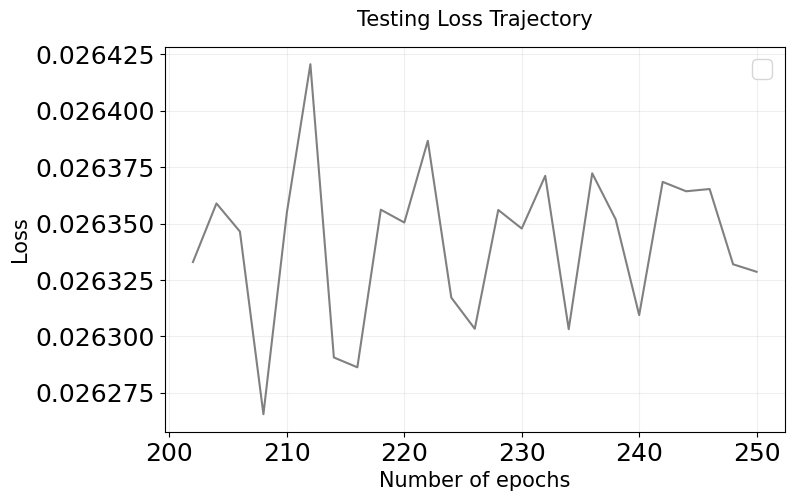

In [ ]:
df_test_lost = pd.read_csv("/content/drive/MyDrive/Regularizer_model_0109/regularizer_PINN_test_loss_0516.csv")

plt.figure(figsize = (8, 5))
plt.plot(df_test_lost.epoch, df_test_lost.loss, color='grey')
plt.grid(alpha=0.2)
plt.legend(loc='upper right')
plt.grid(alpha=0.2)
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.title('Testing Loss Trajectory', fontsize=15, pad = 15)

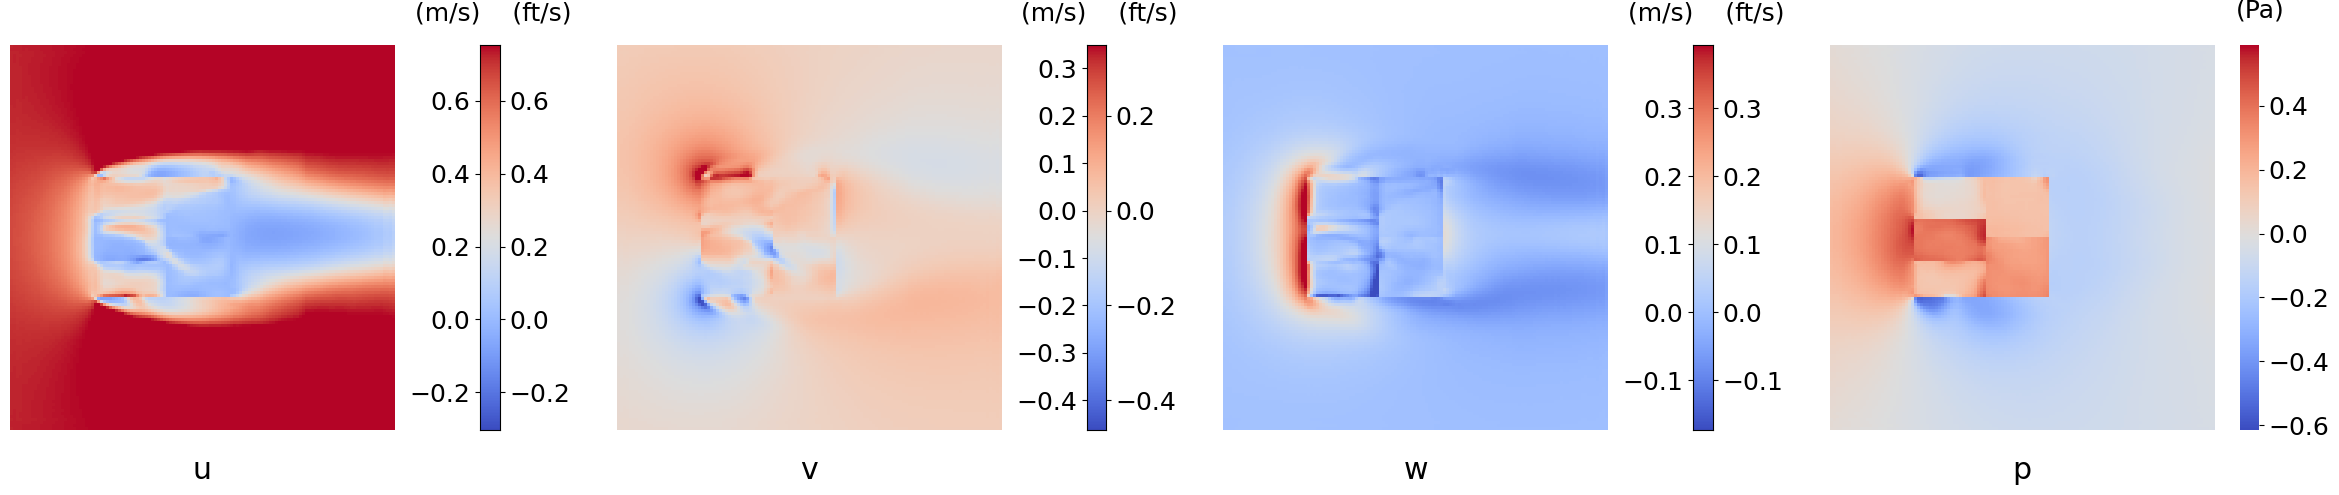

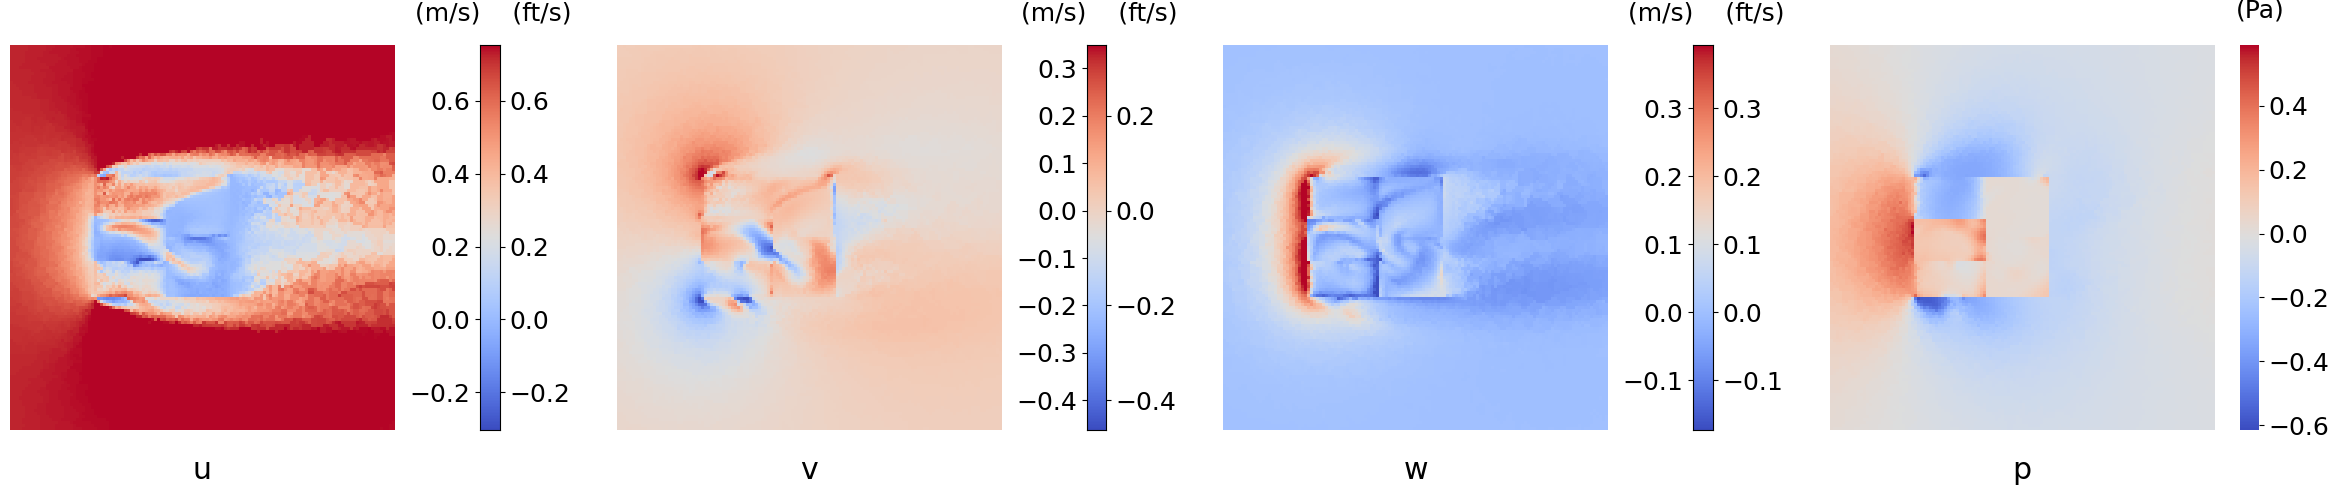

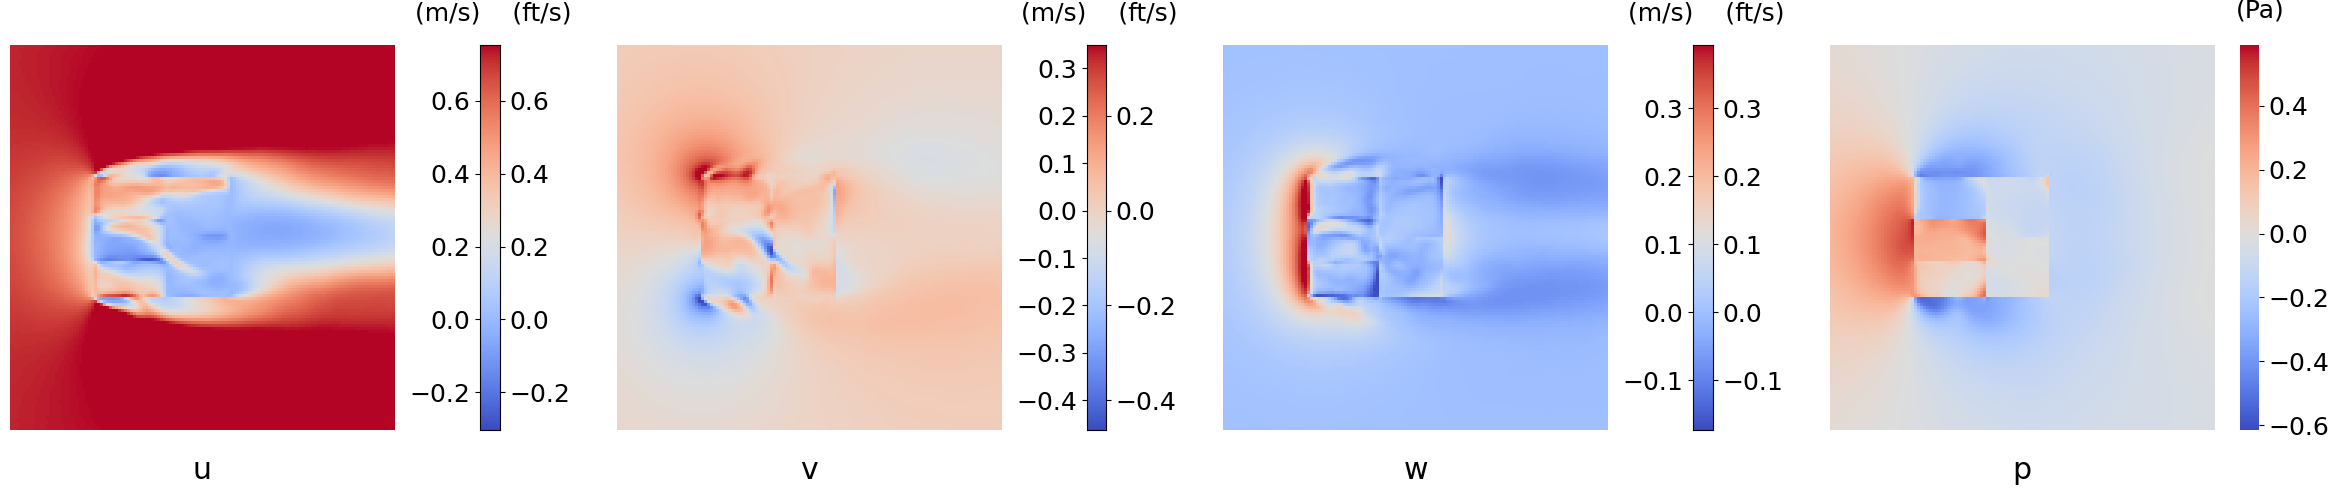

In [ ]:
z = 10 # 0~16
matplotlib.rcParams.update({'font.size': 18})

u_min, u_max = np.amin(cfd_mx[0,:,:,z,0], axis=(0,1)), np.amax(cfd_mx[0,:,:,z,0], axis=(0,1))
v_min, v_max = np.amin(cfd_mx[0,:,:,z,1], axis=(0,1)), np.amax(cfd_mx[0,:,:,z,1], axis=(0,1))
w_min, w_max = np.amin(cfd_mx[0,:,:,z,2], axis=(0,1)), np.amax(cfd_mx[0,:,:,z,2], axis=(0,1))
p_min, p_max = np.amin(cfd_mx[0,:,:,z,3], axis=(0,1)), np.amax(cfd_mx[0,:,:,z,3], axis=(0,1))
bnds = [[u_min/1.2, u_max/1.2], [v_min/1.2, v_max/1.2], [w_min/1.2, w_max/1.2], [p_min/1.2, p_max/1.2]]
# bnds = [[u_min, u_max], [v_min, v_max], [w_min, w_max], [p_min, p_max]]
uvw = ["u", "v", "w"]

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(30, 5))
for i in range(3):
    ax[i] = sns.heatmap(comp_mx.numpy()[0,:,:,z,i+1].T, ax = ax[i], square = True, cmap="coolwarm", vmin=bnds[i][0], vmax=bnds[i][1])
    ax[i].invert_yaxis()
    ax[i].axis('off')
    ax[i].set_title(uvw[i], y=-0.15)
    ax[i].collections[0].colorbar.ax.locator_params(nbins=10)
    cbar0 = ax[i].collections[0].colorbar
    
    pos = cbar0.ax.get_position()
    # print(cbar0.ax.get_yticks())
    # print(cbar0.ax.get_ylim())
    #newpos = np.interp(cbar0.ax.get_yticks(), cbar0.ax.get_ylim(), cbar0.get_clim())
    #newlabel = (newpos*3.28084).round(2)

    pos.x0 += 0.02
    pos.x1 += 0.02
    ax1 = cbar0.ax
    ax1.set_aspect('auto')
    ax1.set_position(pos)
    ax1.yaxis.set_ticks_position('left')
    ax1.yaxis.set_label_position('left')
    ax1.set_ylabel('(m/s)    (ft/s)', rotation=0, labelpad=-60, y=1.05)

    ax2 = ax1.twinx()
    ax2.set_position(pos)
    ax2.set_ylim([bnds[i][0], bnds[i][1]])
    ax2.yaxis.set_ticks_position('right')
    ax2.yaxis.set_label_position('right')
    #ax2.set_yticks(newpos)
    #ax2.set_yticklabels(newlabel)

ax[3] = sns.heatmap(comp_mx.numpy()[0,:,:,z,4].T, ax = ax[3], square = True, cmap="coolwarm", vmin=p_min, vmax=p_max)
ax[3].invert_yaxis()
ax[3].axis('off')
ax[3].set_title("p", y=-0.15)
# ax[3].collections[0].colorbar.outline.set_visible(True)
cbar3 = ax[3].collections[0].colorbar
cbar3.ax.set_ylabel('(Pa)', rotation=0, labelpad=-50, y=1.12)
cbar3.ax.locator_params(nbins=10)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(30, 5))
for i in range(3):
    ax[i] = sns.heatmap(cfd_mx.numpy()[0,:,:,z,i].T, ax = ax[i], square = True, cmap="coolwarm", vmin=bnds[i][0], vmax=bnds[i][1])
    ax[i].invert_yaxis()
    ax[i].axis('off')
    ax[i].set_title(uvw[i], y=-0.15)
    ax[i].collections[0].colorbar.ax.locator_params(nbins=10)
    cbar0 = ax[i].collections[0].colorbar
    
    pos = cbar0.ax.get_position()
    # print(cbar0.ax.get_yticks())
    # print(cbar0.ax.get_ylim())
    #newpos = np.interp(cbar0.ax.get_yticks(), cbar0.ax.get_ylim(), cbar0.get_clim())
    #newlabel = (newpos*3.28084).round(2)

    pos.x0 += 0.02
    pos.x1 += 0.02
    ax1 = cbar0.ax
    ax1.set_aspect('auto')
    ax1.set_position(pos)
    ax1.yaxis.set_ticks_position('left')
    ax1.yaxis.set_label_position('left')
    ax1.set_ylabel('(m/s)    (ft/s)', rotation=0, labelpad=-60, y=1.05)

    ax2 = ax1.twinx()
    ax2.set_position(pos)
    ax2.set_ylim([bnds[i][0], bnds[i][1]])
    ax2.yaxis.set_ticks_position('right')
    ax2.yaxis.set_label_position('right')
    #ax2.set_yticks(newpos)
    #ax2.set_yticklabels(newlabel)

ax[3] = sns.heatmap(cfd_mx.numpy()[0,:,:,z,3].T, ax = ax[3], square = True, cmap="coolwarm", vmin=p_min, vmax=p_max)
ax[3].invert_yaxis()
ax[3].axis('off')
ax[3].set_title("p", y=-0.15)
# ax[3].collections[0].colorbar.outline.set_visible(True)
cbar3 = ax[3].collections[0].colorbar
cbar3.ax.set_ylabel('(Pa)', rotation=0, labelpad=-50, y=1.12)
cbar3.ax.locator_params(nbins=10)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(30, 5))
for i in range(3):
    ax[i] = sns.heatmap(pred_mx[0,:,:,z,i].T, ax = ax[i], square = True, cmap="coolwarm", vmin=bnds[i][0], vmax=bnds[i][1])
    ax[i].invert_yaxis()
    ax[i].axis('off')
    ax[i].set_title(uvw[i], y=-0.15)
    ax[i].collections[0].colorbar.ax.locator_params(nbins=10)
    cbar0 = ax[i].collections[0].colorbar
    
    pos = cbar0.ax.get_position()
    #newpos = np.interp(cbar0.ax.get_yticks(), cbar0.ax.get_ylim(), cbar0.get_clim())
    #newlabel = (newpos*3.28084).round(2)

    pos.x0 += 0.02
    pos.x1 += 0.02
    ax1 = cbar0.ax
    ax1.set_aspect('auto')
    ax1.set_position(pos)
    ax1.yaxis.set_ticks_position('left')
    ax1.yaxis.set_label_position('left')
    ax1.set_ylabel('(m/s)    (ft/s)', rotation=0, labelpad=-60, y=1.05)

    ax2 = ax1.twinx()
    ax2.set_position(pos)
    ax2.set_ylim([bnds[i][0], bnds[i][1]])
    ax2.yaxis.set_ticks_position('right')
    ax2.yaxis.set_label_position('right')
    #ax2.set_yticks(newpos)
    #ax2.set_yticklabels(newlabel)

ax[3] = sns.heatmap(pred_mx[0,:,:,z,3].T, ax = ax[3], square = True, cmap="coolwarm", vmin=p_min, vmax=p_max)
ax[3].invert_yaxis()
ax[3].axis('off')
ax[3].set_title("p", y=-0.15)
cbar3 = ax[3].collections[0].colorbar
cbar3.ax.set_ylabel('(Pa)', rotation=0, labelpad=-50, y=1.12)
cbar3.ax.locator_params(nbins=10)

In [ ]:
#csv_file_pth = "/content/drive/MyDrive/Regularizer_model_0109/regularizer_PINN_loss_0516.csv"
#csv_file_pth = "/content/drive/MyDrive/Regularizer_model_0109/regularizer_PINN_mae_loss_0516.csv"
csv_file_pth = "/content/drive/MyDrive/Regularizer_model_0109/regularizer_PINN_phy_loss_0516.csv"
df = pd.read_csv(csv_file_pth)
df

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
0,0.035001,0.038725,0.034868,0.040228,0.026958,0.029020,0.026948,0.039043,0.030257,0.031750,...,0.031117,0.025084,0.035912,0.039846,0.030285,0.033865,0.033699,0.041830,0.026312,0.029283
1,0.034202,0.038035,0.034004,0.039610,0.026744,0.028577,0.026813,0.038527,0.029951,0.031516,...,0.031424,0.024997,0.035774,0.040272,0.030052,0.033510,0.033186,0.040680,0.025294,0.028568
2,0.033774,0.037273,0.033463,0.039118,0.026310,0.028044,0.026027,0.037914,0.029559,0.030902,...,0.031290,0.025087,0.035644,0.039186,0.029973,0.033632,0.033548,0.040533,0.025586,0.028784
3,0.033549,0.037047,0.033216,0.038731,0.025679,0.027469,0.025417,0.037484,0.028965,0.030209,...,0.030614,0.024945,0.035485,0.038788,0.029703,0.033254,0.033454,0.040339,0.025951,0.028921
4,0.033102,0.037052,0.033144,0.038590,0.025454,0.027650,0.025903,0.037209,0.028722,0.030227,...,0.029873,0.024519,0.035336,0.039608,0.029393,0.032849,0.032775,0.040031,0.025527,0.028283
5,0.032751,0.036569,0.032577,0.037942,0.025366,0.027505,0.025911,0.036725,0.028469,0.030207,...,0.029688,0.023952,0.034714,0.038703,0.029039,0.032394,0.032324,0.039539,0.024744,0.027753
6,0.032564,0.036100,0.032252,0.037350,0.025254,0.026943,0.025200,0.036120,0.028184,0.029562,...,0.029949,0.023920,0.034443,0.037597,0.028735,0.032256,0.031960,0.038746,0.024177,0.027388
7,0.032373,0.035701,0.031959,0.037273,0.025214,0.026666,0.024591,0.036163,0.028201,0.029105,...,0.029898,0.023896,0.034118,0.037121,0.028692,0.032167,0.031913,0.038829,0.024388,0.027479
8,0.032034,0.035437,0.031708,0.037212,0.024771,0.026439,0.024292,0.035853,0.027801,0.028940,...,0.029464,0.023861,0.033840,0.037130,0.028295,0.031990,0.031646,0.038431,0.024547,0.027430
9,0.031782,0.035231,0.031498,0.037121,0.024468,0.026367,0.024441,0.035742,0.027508,0.028972,...,0.028932,0.023572,0.033683,0.036908,0.028128,0.031538,0.031466,0.038387,0.024542,0.027326


In [ ]:
df.mean(axis=1)

0     0.033641
1     0.033248
2     0.032913
3     0.032564
4     0.032241
5     0.031926
6     0.031624
7     0.031327
8     0.031037
9     0.030753
10    0.030451
11    0.030167
12    0.029913
13    0.029658
14    0.029412
15    0.029162
16    0.028878
17    0.028626
18    0.028396
19    0.028153
20    0.027944
21    0.027726
22    0.027509
23    0.027307
24    0.027072
25    0.026864
26    0.026646
27    0.026433
28    0.026247
29    0.026056
30    0.025868
31    0.025670
32    0.025490
33    0.025326
34    0.025163
35    0.024990
36    0.024830
37    0.024680
38    0.024508
39    0.024348
40    0.024191
41    0.024058
42    0.023924
43    0.023763
44    0.023602
45    0.023455
46    0.023327
47    0.023185
48    0.023040
49    0.022903
dtype: float64

<Axes: >

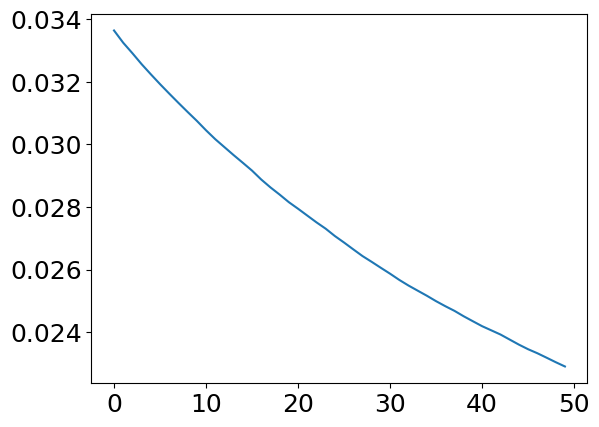

In [ ]:
df.mean(axis=1).plot()